In [4]:
from os import path
import pandas as pd
from config import SIMILARITY_PATH, EMBEDDING_PATH, PRETRAIN_OUTPUT_PATH
from emb_extr_res.emb_extr_res import get_embeddings_df, get_pairs_similarity_df, get_pretrain_agg_similarity
from load_data.wdc.load_wdc_dataset import EnglishDatasetLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import jaro
from rapidfuzz.distance import Levenshtein
from tqdm import tqdm

In [5]:
def jaccard_similarity(x,y):
    sentences = [x,y]
    sentences = [sent.lower().split(" ") for sent in sentences]

    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)


In [6]:
dataset_type = "computers"
dataset_size = "medium"

In [7]:
train_df = EnglishDatasetLoader.load_train(dataset_type, dataset_size)

In [8]:
def calculate_string_metric(string1, string2):

    jaro_metric = jaro.jaro_winkler_metric(string1, string2)
    lev_metric = Levenshtein.normalized_similarity(string1, string2)
    jacard_metric = jaccard_similarity(string1, string2)

    
    return jaro_metric, lev_metric, jacard_metric

In [9]:
def extract_titles(df_train, id_1= 0, id_0 = 1762):

    df_train_1 = df_train[df_train["label"]==1]
    df_train_0 = df_train[df_train["label"]==0]

    sample_similar = df_train_1.loc[id_1,["title_left", "title_right"]].values
    sample_nonsimilar = df_train_0.loc[id_0,["title_left", "title_right"]].values
    
    measures_similar = calculate_string_metric(sample_similar[0], sample_similar[1])
    measures_nonsimilar = calculate_string_metric(sample_nonsimilar[0], sample_nonsimilar[1])

    return sample_similar, measures_similar, sample_nonsimilar, measures_nonsimilar


In [10]:
def calculate_statistics_metric(train_df):

    df_train_1 = train_df[train_df["label"]==1]
    df_train_0 = train_df[train_df["label"]==0]

    similarity_1_jaro = []
    similarity_1_leven = []
    similarity_1_jaccard = []

    similarity_0_jaro = []
    similarity_0_leven = []
    similarity_0_jaccard = []



    for string1, string2 in tqdm(df_train_1[["title_left", "title_right"]].values):

        javo, leven, jaccard = calculate_string_metric(string1, string2)
        similarity_1_jaro.append(javo)
        similarity_1_leven.append(leven)
        similarity_1_jaccard.append(jaccard)


    for string1, string2 in tqdm(df_train_0[["title_left", "title_right"]].values):

        javo, leven, jaccard = calculate_string_metric(string1, string2)
        similarity_0_jaro.append(javo)
        similarity_0_leven.append(leven)
        similarity_0_jaccard.append(jaccard)


    plt.hist(similarity_0_jaro, label="non similar", alpha=  0.5, density=True)
    plt.hist(similarity_1_jaro, label = "similar", alpha=  0.5, density=True)

    plt.title("Javo metric")
    plt.legend()
    plt.show()
    
    plt.hist(similarity_0_leven, label="non similar", alpha=  0.5, density=True)
    plt.hist(similarity_1_leven, label="similar", alpha=  0.5, density=True)

    plt.title("Levenstein metric")
    plt.legend()
    plt.show()
    

    plt.hist(similarity_0_jaccard, label="non similar", alpha=  0.5, density=True)
    plt.hist(similarity_1_jaccard, label="similar", alpha=  0.5, density=True)

    plt.title("Jaccard metric")
    plt.legend()

    plt.show()






100%|██████████| 6332/6332 [00:01<00:00, 5526.41it/s]


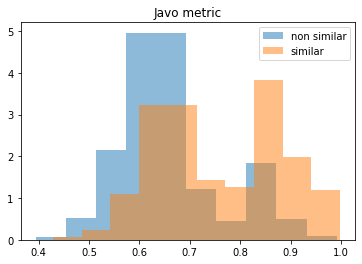

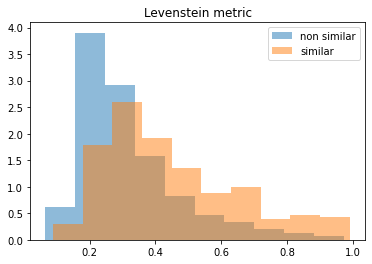

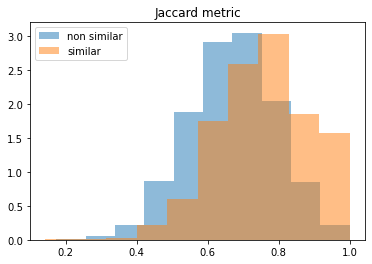

In [107]:
calculate_statistics_metric(train_df)

### Same offers

In [17]:
print("Sentance 1: ", extract_titles(train_df)[0][0])
print("Sentance 2: ", extract_titles(train_df)[0][1])
print("Javo metric: ", extract_titles(train_df)[1][0])
print("Levenstein metric", extract_titles(train_df)[1][1])
print("Jaccard metric: ", extract_titles(train_df)[1][2])


Sentance 1:  495906 b21 hp x5560 2 80ghz ml350 g6 , null new wholesale price
Sentance 2:  null , 495906 b21 hp x5560 2 80ghz ml350 g6
Javo metric:  0.6881619672317346
Levenstein metric 0.46031746031746035
Jaccard metric:  0.7241379310344828


### DIfferent Offers

In [27]:
print("Sentance 1: ", extract_titles(train_df, id_0 = 1768)[2][0])
print("Sentance 2: ", extract_titles(train_df, id_0 = 1768)[2][1])
print("Javo metric: ", extract_titles(train_df, id_0 = 1768)[3][0])
print("Levenstein metric", extract_titles(train_df, id_0 = 1768)[3][1])
print("Jaccard metric: ", extract_titles(train_df, id_0 = 1768)[3][2])


Sentance 1:  495906 b21 hp x5560 2 80ghz ml350 g6 , null new wholesale price
Sentance 2:  hp amd opteron 8384 prijzen tweakers
Javo metric:  0.511904761904762
Levenstein metric 0.2063492063492064
Jaccard metric:  0.48484848484848486
